<a href="https://www.kaggle.com/code/rashidrk/tb-detection-with-yolo-12?scriptVersionId=233372449" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
!pip install ultralytics -q
from PIL import Image, ImageDraw
from pathlib import Path
import os
import xml.etree.ElementTree as ET
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml
import matplotlib.patches as patches
import random
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 34.7 MB/s eta 0:00:00


In [2]:
annotations_path = Path("/kaggle/input/tbx-11/TBX11K/annotations/xml")
images_path = Path("/kaggle/input/tbx-11/TBX11K/imgs")

annotations = os.listdir(annotations_path)
images = os.listdir(images_path)

annotations.sort()
images.sort()

In [3]:
def read_file_paths(file_path : str):
    with open(file_path, 'r') as f:
        all_files = f.readlines()
        return all_files


train_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_train.txt")
test_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")
val_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")

test_paths[:4]

['test/unknown_1.png\n',
 'test/unknown_2.png\n',
 'test/unknown_3.png\n',
 'test/unknown_4.png\n']

In [4]:
len(train_paths)

6888

In [5]:
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Basic file info
    filename = root.find('filename').text
    segmented = int(root.find('segmented').text)

    # Image size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = int(obj.find('truncated').text)
        difficult = int(obj.find('difficult').text)

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        annotations.append({
            'name': name,
            'pose': pose,
            'truncated': truncated,
            'difficult': difficult,
            'bbox': {
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            }
        })

    return {
        'filename': filename,
        'segmented': segmented,
        'size': {
            'width': width,
            'height': height
        },
        'objects': annotations
    }


In [6]:
parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

{'filename': 'tb0003',
 'segmented': 0,
 'size': {'width': 2840, 'height': 2827},
 'objects': [{'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 1446, 'ymin': 250, 'xmax': 2007, 'ymax': 1017}},
  {'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 618, 'ymin': 391, 'xmax': 1177, 'ymax': 1013}}]}

In [7]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [8]:
def plot_image_with_bboxes(image_path, annotation_data):
    # Load and resize the image to match annotation size
    image = Image.open(image_path)
    annotated_width = annotation_data['size']['width']
    annotated_height = annotation_data['size']['height']
    image = image.resize((annotated_width, annotated_height))

    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Assign unique colors to each class
    # class_names = list(set(obj['name'] for obj in annotation_data['objects']))
    # color_map = {cls: (random.random(), random.random(), random.random()) for cls in class_names}

    # Draw each bounding box
    for obj in annotation_data['objects']:
        bbox = obj['bbox']
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        box_width = xmax - xmin
        box_height = ymax - ymin

        label = obj['name']

        # Draw rectangle
        rect = patches.Rectangle(
            (xmin, ymin), box_width, box_height,
            linewidth=2, edgecolor="red", facecolor='none'
        )
        ax.add_patch(rect)

        # Add class label
        ax.text(xmin, ymin - 5, label, color="red", fontsize=10, weight='bold', backgroundcolor='white')

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
annotations[-1]

'tb1199.xml'

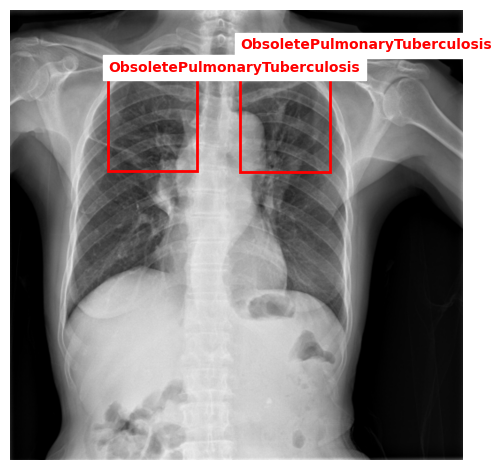

In [10]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0003.png", objects)

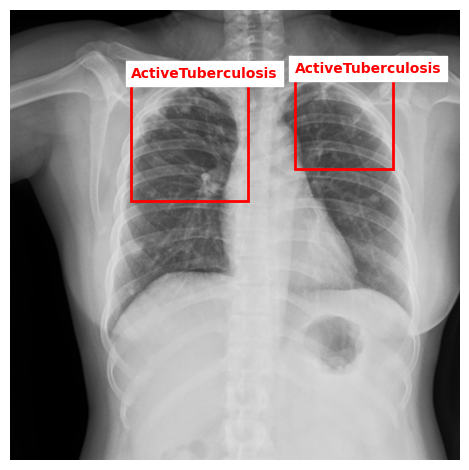

In [11]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0235.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0235.png", objects)

In [12]:
classes_set = set([])

for annon in annotations:
    objects = parse_xml(annotations_path / annon)
    objects = objects['objects']
    for obj in objects:
        classes_set.add(obj['name'])

In [13]:
classes_set

{'ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis'}

# prep data for training

In [14]:
class_map = {
    "TB" : 0
}

In [15]:
def convert_to_yolo_format(xml_path, output_dir):
    """
    Converts XML annotations to YOLO format.

    Args:
        xml_path: Path to the XML annotation file.
        output_dir: Directory to save the YOLO annotation files.
        class_map: Dict mapping class names to YOLO class IDs

    Returns:
        None: Saves YOLO annotation files to output_dir.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Image size
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)

    yolo_annotations = []

    for obj in root.findall('object'):
        name = obj.find('name').text

        # Bounding box
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Normalize for YOLO format
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        box_width = (xmax - xmin) / img_width
        box_height = (ymax - ymin) / img_height

        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    # Save to .txt file in YOLO format
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / (xml_path.stem + ".txt")
    
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_annotations))


In [16]:
annotations = [annotations_path / annon for annon in annotations]
annotations[:10]

[PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0004.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0005.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0006.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0007.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0009.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0012.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0014.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0015.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0017.xml')]

In [17]:
train_data, val_data = train_test_split(annotations, random_state = 42, test_size = 0.2)

In [18]:
output_dir = Path("/kaggle/working/")

directories = ['train', 'val']
for data_dir in directories:
    images_output_dir = output_dir / f"{data_dir}/images"
    labels_output_dir = output_dir / f"{data_dir}/labels"

    os.makedirs(images_output_dir, exist_ok = True)
    os.makedirs(labels_output_dir, exist_ok = True)

In [19]:
directories_dict = {
    "train" : Path("/kaggle/working/train"),
    "val" : Path("/kaggle/working/val")
}

In [20]:
annotations[0].stem

'tb0003'

In [21]:
def move_image_to_dir(image_path, images_output_dir):
    image = Image.open(image_path)
    images_output_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    image.save(images_output_dir / Path(image_path).name)


def generate_yolo_dir(data_list : List, data_dir):
    images_output_dir = directories_dict[data_dir] / "images"
    labels_output_dir = directories_dict[data_dir] / "labels"
    
    for annon_path in tqdm(
        data_list,
        total=len(data_list),
        desc="Processing Images and Annotations"
    ):
        img_path = images_path / "tb" / f"{annon_path.stem}.png"
        move_image_to_dir(img_path, images_output_dir)
        convert_to_yolo_format(annon_path, labels_output_dir)

In [22]:
generate_yolo_dir(train_data, "train")

Processing Images and Annotations: 100%|██████████| 640/640 [00:55<00:00, 11.62it/s]


In [23]:
generate_yolo_dir(val_data, "val")

Processing Images and Annotations: 100%|██████████| 160/160 [00:14<00:00, 11.20it/s]


In [24]:
# display one of the files
with open("/kaggle/working/train/labels/tb0003.txt") as f:
    print(f.read())

0 0.607923 0.224089 0.197535 0.271312
0 0.316021 0.248320 0.196831 0.220021


In [25]:
num_classes = 1
names = ['TB']

dict_file = {
    'train': str(directories_dict['train']),
    'val': str(directories_dict['val']),
    'nc': num_classes,
    'names': names,
    'augment': { # apply data augmentations
        'flipud': 0.0,  # Probability of vertical flip
        'fliplr': 0.5,  # Probability of horizontal flip
        'hsv_h': 0.015,  # HSV hue augmentation 
        'hsv_s': 0.7,  # HSV saturation augmentation
        'hsv_v': 0.4   # HSV value augmentation
    }
}

# Save to the data.yaml file
with open("/kaggle/working/data.yaml", 'w') as file:
    yaml.dump(dict_file, file, default_flow_style=False)

In [26]:
# display 
with open("/kaggle/working/data.yaml", "r") as f:
    print(f.read())

augment:
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
names:
- TB
nc: 1
train: /kaggle/working/train
val: /kaggle/working/val



In [27]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
except Exception as e:
    print(e)
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rashidkisejjere0784. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
from ultralytics import YOLO

model = YOLO('yolo12m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 39.0M/39.0M [00:00<00:00, 312MB/s]


In [29]:
results = model.train(data="/kaggle/working/data.yaml",
                      epochs=80,
                      patience=40,
                      cos_lr = True,
                      seed = 42)

Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/data.yaml, epochs=80, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 40.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2689536  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 161MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 640 images, 1 backgrounds, 0 corrupt: 100%|██████████| 640/640 [00:00<00:00, 1148.26it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/val/labels... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 979.29it/s]

val: New cache created: /kaggle/working/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0005), 129 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      12.2G      2.266      3.649      2.391         30        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      13.3G      2.247      2.835       2.34         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      13.3G      2.282      2.685      2.338         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        160        247    0.00351      0.599    0.00303   0.000841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      13.3G      2.165      2.528      2.247         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      13.3G      2.177      2.508       2.23         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:02<00:00,  1.66it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        160        247   0.000107     0.0202   5.45e-05    8.7e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      13.3G       2.09      2.437      2.164         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        160        247      0.109     0.0769     0.0298    0.00795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      13.3G      2.064      2.341      2.131         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        160        247       0.24      0.304      0.199     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      13.3G      2.022      2.356      2.099         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247     0.0314      0.291     0.0171    0.00455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      13.3G      2.043      2.316      2.106         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.307      0.409       0.29     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      13.3G      2.061      2.326      2.102         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247     0.0574     0.0405     0.0152    0.00272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      13.3G      2.013      2.251      2.073         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.208      0.413      0.188     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      13.3G      1.955      2.153      2.058         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.339      0.376      0.328       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      13.3G      1.925      2.202      2.043         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.224      0.198      0.133     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      13.3G       1.95      2.124      2.025         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.277     0.0891      0.105       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      13.3G      1.912      2.107      1.999         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.158      0.182     0.0794     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      13.3G      1.923      2.119      2.017         47        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247      0.332      0.364      0.298      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      13.3G      1.942      2.113      2.038         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247     0.0783      0.202     0.0346    0.00855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      13.3G       1.94       2.04      2.014         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.549      0.433      0.444      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      13.3G      1.947      2.081      1.985         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.468      0.377      0.367       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      13.3G      1.898       2.05          2         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.316      0.142      0.119     0.0316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      13.3G      1.868      1.991      1.965         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.563      0.498      0.542      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      13.3G      1.865      1.956      1.946         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.506      0.409       0.44      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      13.3G      1.846      1.961      1.938         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.599      0.459      0.524      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      13.3G      1.861      1.901       1.94         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.523      0.494      0.472      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      13.3G      1.819      1.907      1.914         49        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.497      0.423      0.397      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      13.3G      1.828      1.907      1.928         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.49      0.518       0.44      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      13.3G      1.861      1.945      1.926         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.546      0.559      0.571      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      13.3G      1.834      1.921      1.925         38        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.604      0.547      0.573      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      13.3G      1.811        1.9      1.889         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247      0.647      0.522      0.606      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      13.3G       1.82      1.861      1.935         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.655      0.494       0.55      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      13.3G      1.791      1.848      1.901         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.716      0.522      0.634      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      13.3G       1.79      1.784      1.883         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.657      0.551        0.6      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      13.3G      1.805        1.8      1.882         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.702      0.582      0.649      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      13.3G      1.763      1.785      1.869         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.661      0.555      0.612      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      13.3G      1.813      1.845      1.906         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.692       0.59      0.651      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      13.3G      1.742      1.787      1.853         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.632      0.584      0.618       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      13.3G      1.775      1.759      1.875         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.759      0.628      0.707      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      13.3G      1.788      1.776      1.868         28        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.703      0.624      0.703      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      13.3G      1.773      1.771      1.878         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.64      0.628      0.656      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      13.3G      1.732      1.744      1.834         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.674      0.569      0.599      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      13.3G      1.719      1.699       1.85         26        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.803      0.643      0.709      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      13.3G      1.732      1.724      1.828         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.712       0.58      0.655       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      13.3G      1.747      1.737      1.863         54        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.721      0.596      0.637      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      13.3G      1.755       1.73      1.882         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.674      0.629      0.642      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      13.3G      1.708      1.652      1.798         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.709       0.64      0.697      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      13.3G      1.734      1.701      1.859         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.777      0.615      0.722      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      13.3G      1.719      1.669      1.846         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.787      0.641      0.695       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      13.3G      1.717      1.658      1.826         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.739      0.668       0.72      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      13.3G      1.673      1.596      1.798         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        160        247      0.784      0.663       0.72      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      13.3G      1.677      1.612      1.789         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.767      0.607      0.667      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      13.3G       1.69      1.591      1.804         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.71       0.68      0.677      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      13.3G      1.648      1.568      1.763         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.78      0.652      0.717      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      13.3G      1.662      1.522      1.773         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.735      0.698      0.734      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      13.3G      1.622      1.523      1.763         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.822      0.672      0.712      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      13.3G      1.671      1.577      1.795         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.752      0.696      0.754      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      13.3G      1.632      1.541      1.752         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.816      0.684      0.738      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      13.3G      1.666      1.614      1.781         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.749      0.676      0.739      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      13.3G      1.633      1.565      1.791         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.76      0.676      0.748      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      13.3G      1.622      1.503      1.753         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.764       0.67      0.743      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      13.3G      1.607      1.478      1.739         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.78      0.684      0.757      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      13.3G      1.625      1.508      1.762         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.741      0.692      0.745       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      13.3G      1.616      1.487      1.743         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.824      0.676      0.766      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      13.3G      1.628      1.495      1.754         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.764      0.656      0.724      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      13.3G      1.623      1.474      1.749         34        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.745      0.711      0.767       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      13.3G      1.623      1.475      1.743         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.798      0.704      0.775       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      13.3G      1.614      1.531      1.741         61        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.789        0.7      0.761      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      13.3G      1.602       1.44      1.761         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.761      0.709      0.772       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      13.3G      1.612      1.445      1.746         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.849      0.638      0.755      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      13.3G      1.564      1.422      1.708         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.788      0.688      0.772      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      13.3G        1.6      1.475      1.739         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.774       0.68      0.762      0.353


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      13.3G      1.589      1.457      1.885         24        640: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.828      0.643      0.747      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      13.3G      1.577      1.386       1.88         25        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.826      0.664      0.773      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      13.3G      1.595      1.381      1.875         23        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.777      0.704      0.774      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      13.3G      1.579      1.365      1.876         21        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.847      0.672      0.775      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      13.3G      1.574      1.347      1.861         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.78      0.729      0.779      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      13.3G      1.556      1.351       1.85         20        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.773      0.716      0.772      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      13.3G      1.555       1.34      1.862         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.82      0.684      0.784      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      13.3G      1.569       1.35      1.903         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.825      0.664      0.776      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      13.3G      1.558      1.352      1.866         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.807      0.695      0.785       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      13.3G      1.551      1.353      1.845         22        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.806      0.713      0.785      0.367



80 epochs completed in 0.922 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,105,683 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


                   all        160        247      0.818       0.68      0.784       0.37


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 15.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


In [30]:
results.results_dict

{'metrics/precision(B)': 0.8181502838381833,
 'metrics/recall(B)': 0.680161943319838,
 'metrics/mAP50(B)': 0.7842469007445809,
 'metrics/mAP50-95(B)': 0.3703993698823273,
 'fitness': 0.4117841229685527}

# Validation

In [31]:
df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
75,76,3152.82,1.55594,1.35072,1.84964,0.77287,0.71639,0.77250,0.36254,1.77441,1.31321,2.09044,0.000039,0.000039,0.000039
76,77,3194.09,1.55455,1.34042,1.86152,0.81988,0.68421,0.78364,0.36620,1.76835,1.31175,2.08067,0.000032,0.000032,0.000032
77,78,3235.40,1.56933,1.35009,1.90344,0.82456,0.66397,0.77605,0.36568,1.76426,1.30882,2.07114,0.000027,0.000027,0.000027
78,79,3276.67,1.55822,1.35208,1.86563,0.80712,0.69463,0.78471,0.37001,1.76811,1.31400,2.07418,0.000023,0.000023,0.000023
79,80,3318.11,1.55099,1.35322,1.84534,0.80577,0.71255,0.78500,0.36735,1.76591,1.30766,2.07433,0.000021,0.000021,0.000021


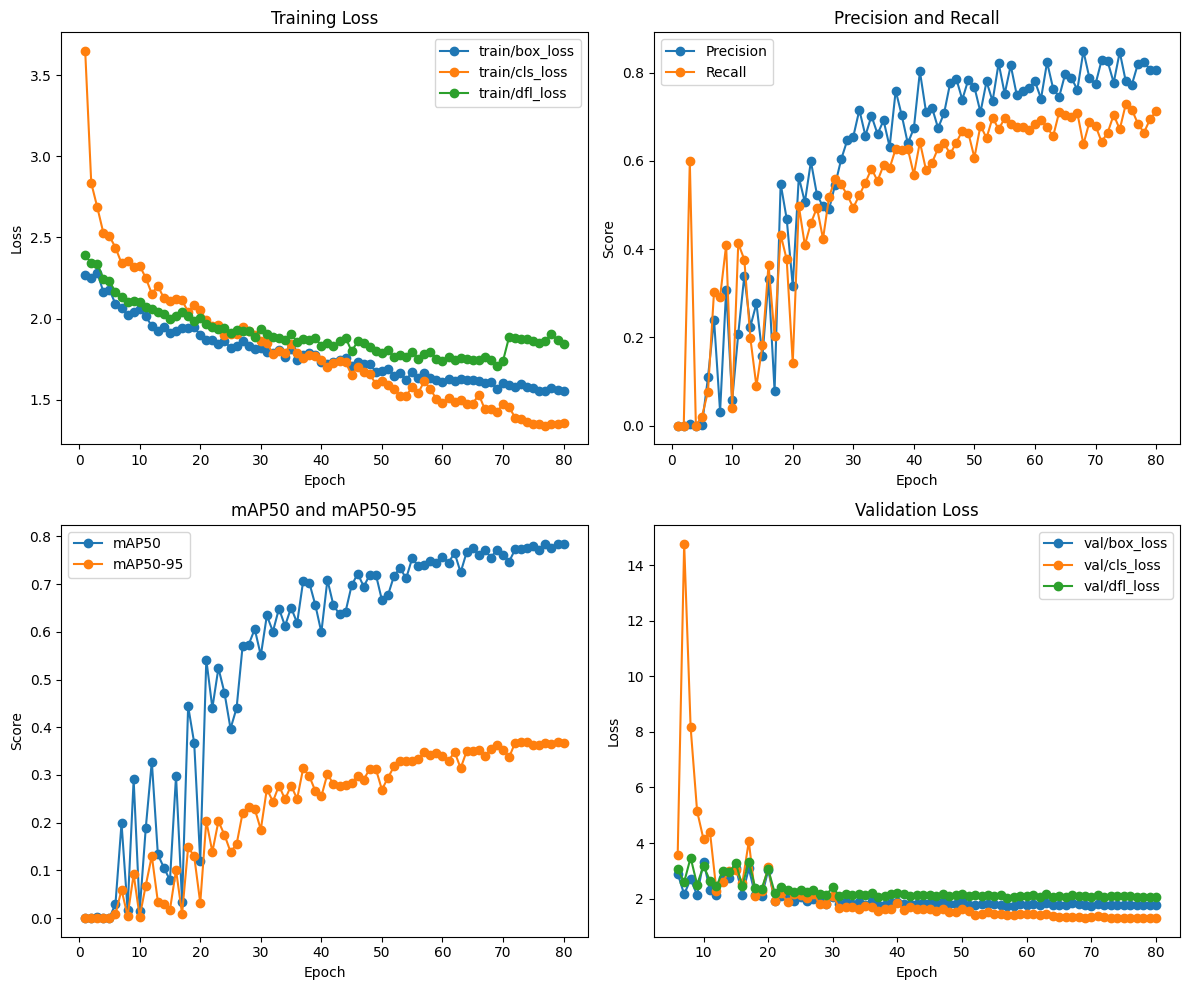

In [32]:
# Plotting selected metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting training loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='train/box_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss', marker='o')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting precision and recall
axes[0, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='o')
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='o')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()

# Plotting mAP50 and mAP50-95
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o')
axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o')
axes[1, 0].set_title('mAP50 and mAP50-95')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()

# Plotting validation loss
axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss', marker='o')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout and display
plt.tight_layout()

In [33]:
results = model.val()

Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,105,683 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


                   all        160        247      0.807      0.694      0.785       0.37


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /kaggle/working/train/images/tb0050.png: 640x640 2 TBs, 19.1ms
Speed: 3.2ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


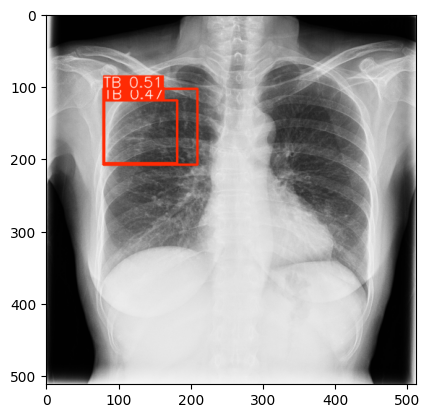

In [34]:
prediction = model.predict("/kaggle/working/train/images/tb0050.png")
plt.imshow(prediction[0].plot())

In [35]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.9 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 300.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 242.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 273.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.3s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 36.4s, saved as 'runs/detect/train/weights/best.onnx' (77.0

'runs/detect/train/weights/best.onnx'